In [1]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

2024-09-17 18:46:47.009519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load preprocessed data and the scaler
X_train = np.load("../data/processed/X_train.npy")
y_train = np.load("../data/processed/y_train.npy")
X_val = np.load("../data/processed/X_val.npy")
y_val = np.load("../data/processed/y_val.npy")
X_test = np.load("../data/processed/X_test.npy")
y_test = np.load("../data/processed/y_test.npy")

scaler = joblib.load("../data/processed/scaler.pkl")

In [3]:
# Define LSTM model architecture
model = Sequential([
    LSTM(512, return_sequences=False, input_shape=(X_train.shape[1], 1)),  # LSTM layer with 50 units
    Dense(1)  # Output layer for predicting stock price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 [==============================] - 8s 230ms/step - loss: 0.0124 - val_loss: 0.0030
Epoch 2/100
27/27 [==============================] - 6s 209ms/step - loss: 6.5194e-04 - val_loss: 0.0011
Epoch 3/100
27/27 [==============================] - 5s 187ms/step - loss: 3.8624e-04 - val_loss: 0.0011
Epoch 4/100
27/27 [==============================] - 5s 196ms/step - loss: 4.1855e-04 - val_loss: 0.0010
Epoch 5/100
27/27 [==============================] - 5s 179ms/step - loss: 3.7911e-04 - val_loss: 9.7052e-04
Epoch 6/100
27/27 [==============================] - 5s 188ms/step - loss: 3.7807e-04 - val_loss: 0.0018
Epoch 7/100
27/27 [==============================] - 5s 186ms/step - loss: 4.7358e-04 - val_loss: 0.0019
Epoch 8/100
27/27 [==============================] - 5s 190ms/step - loss: 4.2156e-04 - val_loss: 0.0011
Epoch 9/100
27/27 [==============================] - 5s 186ms/step - loss: 3.5302e-04 - val_loss: 0.0012
Epoch 10/100
27/27 [==============================] - 5

In [4]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
val_loss = model.evaluate(X_val, y_val)
test_loss = model.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

6/6 [==============================] - 0s 30ms/step - loss: 7.1715e-04
Training Loss: 0.00018075309344567358
Validation Loss: 0.0005987595650367439
Test Loss: 0.0007171514444053173


**Loss Values:**
- Training Loss: `0.0001808`
- Validation Loss: `0.0005988`
- Test Loss: `0.0007172`
    - **Training Loss:** The training loss is quite low, indicating that the model is fitting the training data well.
    - **Validation Loss:** The validation loss is also low and reasonably close to the training loss, which suggests good generalization.
    - **Test Loss:** The test loss is slightly higher but still relatively low, indicating that the model generalizes well to new, unseen data.


In [5]:
# Make predictions
y_pred = model.predict(X_test)

6/6 [==============================] - 1s 29ms/step


In [6]:
# Reverse the scaling for predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

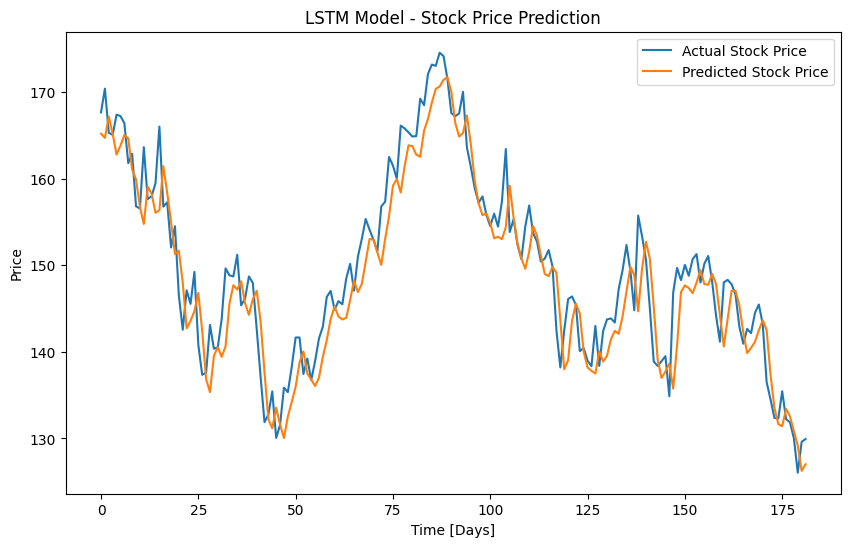

In [10]:
# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label="Actual Stock Price")
plt.plot(y_pred_rescaled, label="Predicted Stock Price")
plt.title("LSTM Model - Stock Price Prediction")
plt.xlabel("Time [Days]")
plt.ylabel("Price")
plt.legend()
plt.savefig("../plots/lstm_model_prediction.png")
plt.show()

In [8]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared (R²)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 3.1460663931710378
R-squared (R²): 0.8691958866977129


**MAE and R² Metrics:**
- **Mean Absolute Error (MAE):** `3.1461`

    - This indicates that, on average, the model’s predictions are off by approximately `3.15` units of the stock price. This is an improvement over the RNN model’s MAE of `3.3400`.

- **R-squared (R²):** `0.8692`

    - An R² value of 0.8692 means the LSTM model explains approximately `86.92%` of the variance in stock prices. This is a significant improvement over the RNN model’s R² value of `0.8472`, indicating that the LSTM model captures more of the variability in stock prices.

### Summary:

- **Performance Improvement:** The LSTM model shows better performance compared to the RNN model, with lower MAE and higher R². This suggests that the LSTM model is better at capturing the underlying patterns in the data.
- **Generalization:** The model performs well on the validation and test sets, indicating good generalization to unseen data.

In [11]:
# Save the lstm model
model.save('../models/lstm_model.keras')